**Install libraries**

In [42]:
!pip install scikit-learn -q

In [32]:
!conda install seaborn -c conda-forge -y -q

Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: ...working... done

# All requested packages already installed.



Loading data from dataset.csv
Dataset shape: (1460, 22) (rows, columns)

STEP 1: DATA PREPROCESSING
Filling missing values in garage-related columns and alley...
Missing values report:
  - GarageArea: 0
  - GarageType: 0
  - Alley: 0
  - TotalBsmtSF: 0
Filtering out rows with zero basement square footage...
  - Rows before filtering: 1460
  - Rows after filtering: 1423
Standardizing text in SaleCondition...
Removing extreme outliers...
  - Removed 22 outliers from LotArea
  - Removed 28 outliers from GrLivArea
  - Removed 23 outliers from TotalBsmtSF
  - Removed 14 outliers from GarageArea
Creating new engineered features...
  - Added: HouseAge, TotalBath
Adding interaction terms for better model performance...
  - Added: Quality_Area, Quality_Age
Applying log transformation to skewed features...
  - Transformed: LotArea, GrLivArea, TotalBsmtSF, SalePrice
Performing manual encoding of categorical variables...
Preprocessing completed successfully
Preparing features and target variable..

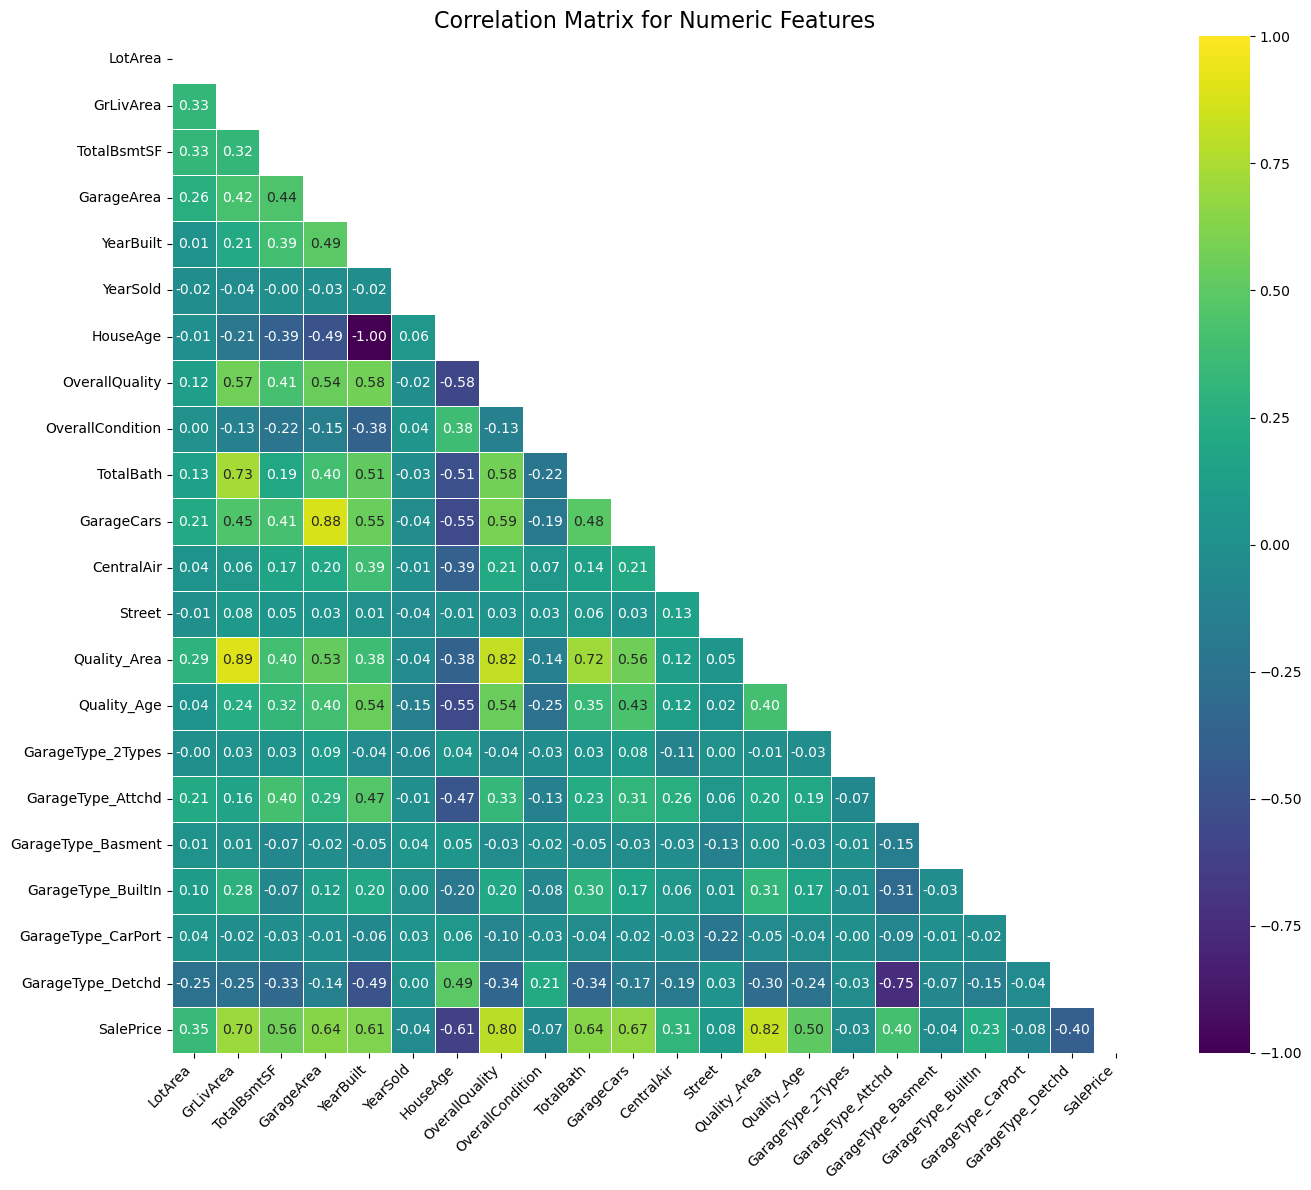


Top correlations with SalePrice:
SalePrice         1.000000
Quality_Area      0.822120
OverallQuality    0.796342
GrLivArea         0.696035
GarageCars        0.665252
GarageArea        0.638070
TotalBath         0.635326
HouseAge          0.611511
YearBuilt         0.610757
TotalBsmtSF       0.561778
Name: SalePrice, dtype: float64

STEP 2: FEATURE SELECTION
Building feature selection pipeline...
Fitting Lasso model for feature selection...
Lasso model fitted
Extracting Lasso coefficients...
Feature coefficients extracted and sorted

Top 10 most important features:
                 Feature  Coefficient  AbsCoefficient
13          Quality_Area     0.137129        0.137129
1              GrLivArea     0.096382        0.096382
2            TotalBsmtSF     0.082686        0.082686
6               HouseAge    -0.081429        0.081429
44          SaleType_New     0.080118        0.080118
7         OverallQuality     0.078607        0.078607
11            CentralAir     0.074594        0.0

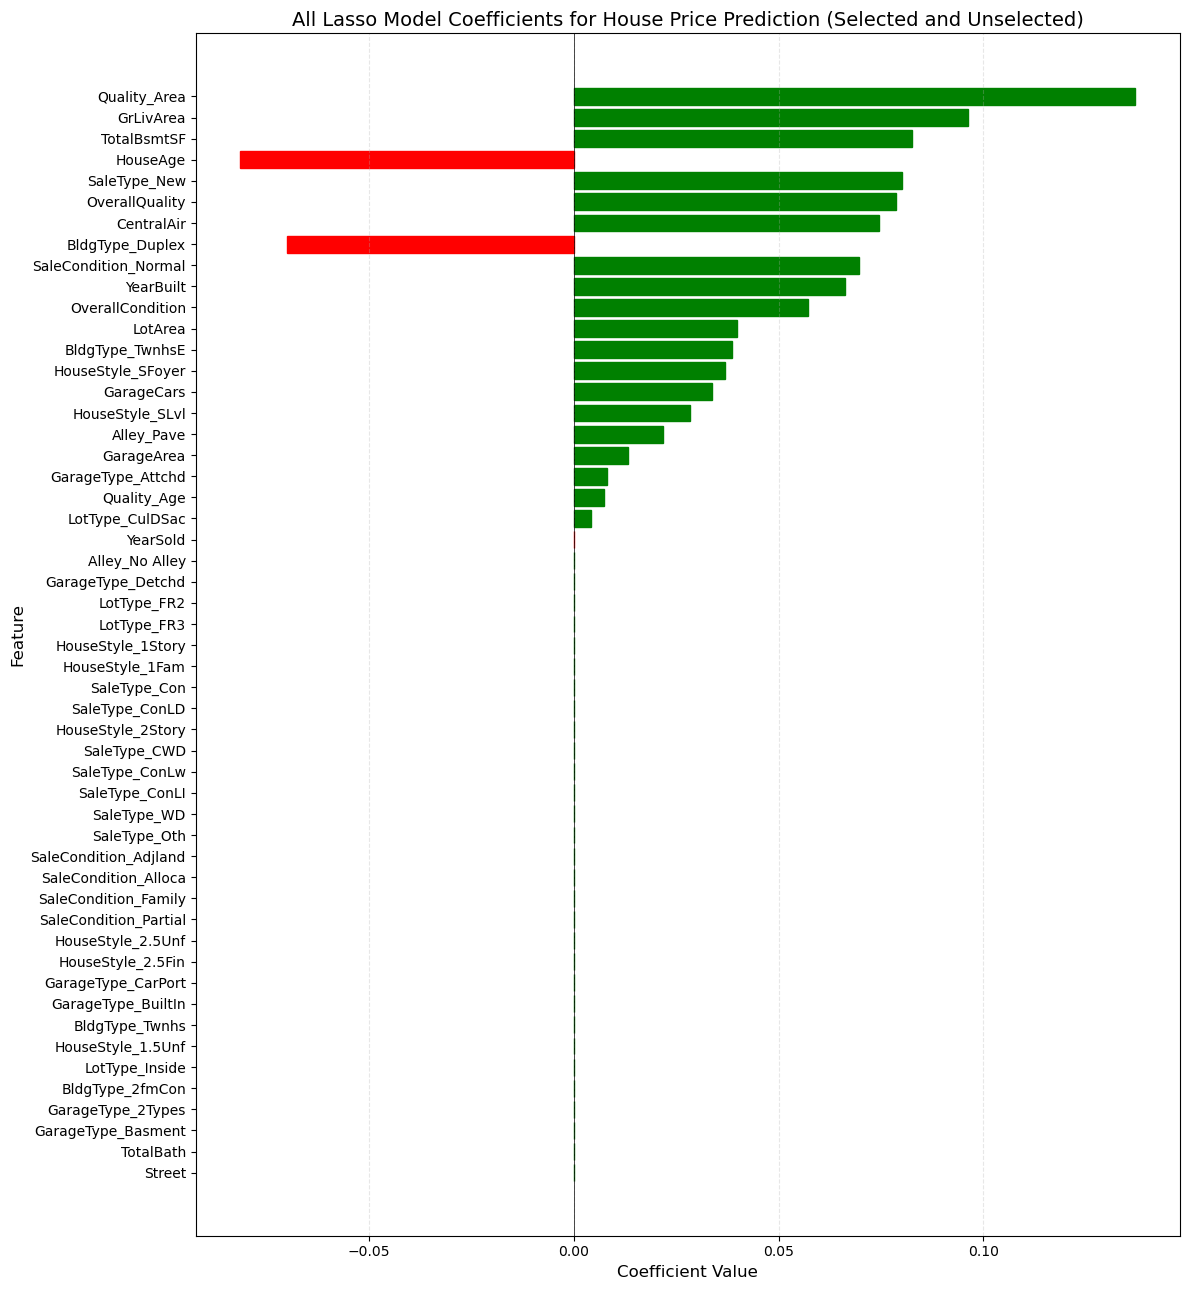

Total features: 52
Features with non-zero coefficients: 22
Features eliminated by Lasso: 30

STEP 3: FINDING OPTIMAL FEATURE SET
Testing different threshold values for feature selection...
  - Testing threshold 0.00 (1/16)... R² = 0.8746 with 22 features
  - Testing threshold 0.01 (2/16)... R² = 0.8756 with 18 features
  - Testing threshold 0.02 (3/16)... R² = 0.8732 with 17 features
  - Testing threshold 0.03 (4/16)... R² = 0.8737 with 15 features
  - Testing threshold 0.04 (5/16)... R² = 0.8574 with 11 features
  - Testing threshold 0.05 (6/16)... R² = 0.8569 with 11 features
  - Testing threshold 0.06 (7/16)... R² = 0.8289 with 10 features
  - Testing threshold 0.07 (8/16)... R² = 0.8257 with 8 features
  - Testing threshold 0.08 (9/16)... R² = 0.8084 with 5 features
  - Testing threshold 0.09 (10/16)... R² = 0.6798 with 2 features
  - Testing threshold 0.10 (11/16)... R² = 0.6663 with 1 features
  - Testing threshold 0.11 (12/16)... R² = 0.6743 with 1 features
  - Testing threshold

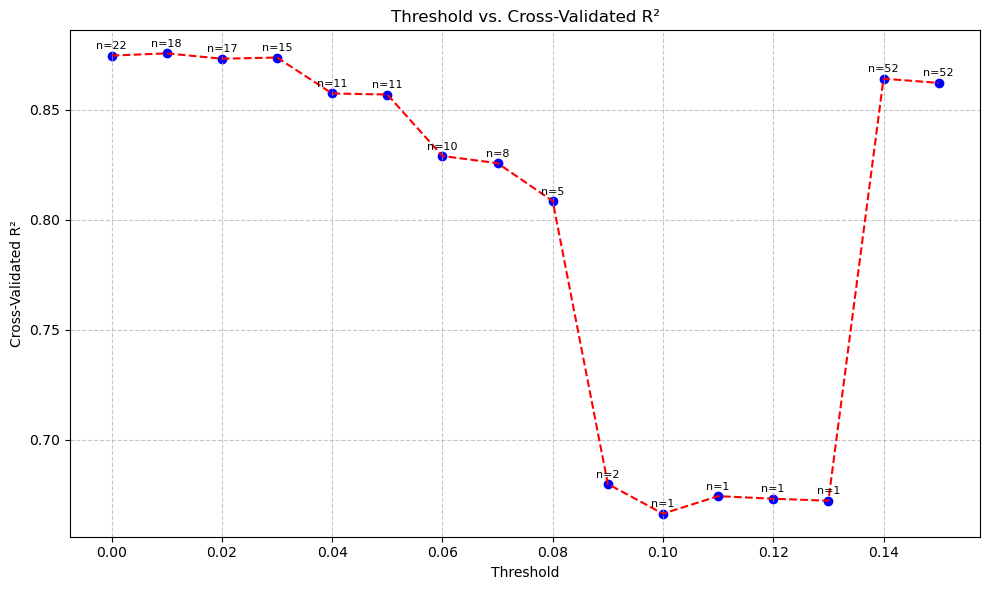

Best threshold found: 0.0100 with R² = 0.8756
Selected 18 features:
  - Quality_Area
  - GrLivArea
  - TotalBsmtSF
  - HouseAge
  - SaleType_New
  - OverallQuality
  - CentralAir
  - BldgType_Duplex
  - SaleCondition_Normal
  - YearBuilt
  - OverallCondition
  - LotArea
  - BldgType_TwnhsE
  - HouseStyle_SFoyer
  - GarageCars
  - HouseStyle_SLvl
  - Alley_Pave
  - GarageArea
Final dataset created with shape: (1336, 18)

Creating scatter plots for ALL 11 selected numeric features...


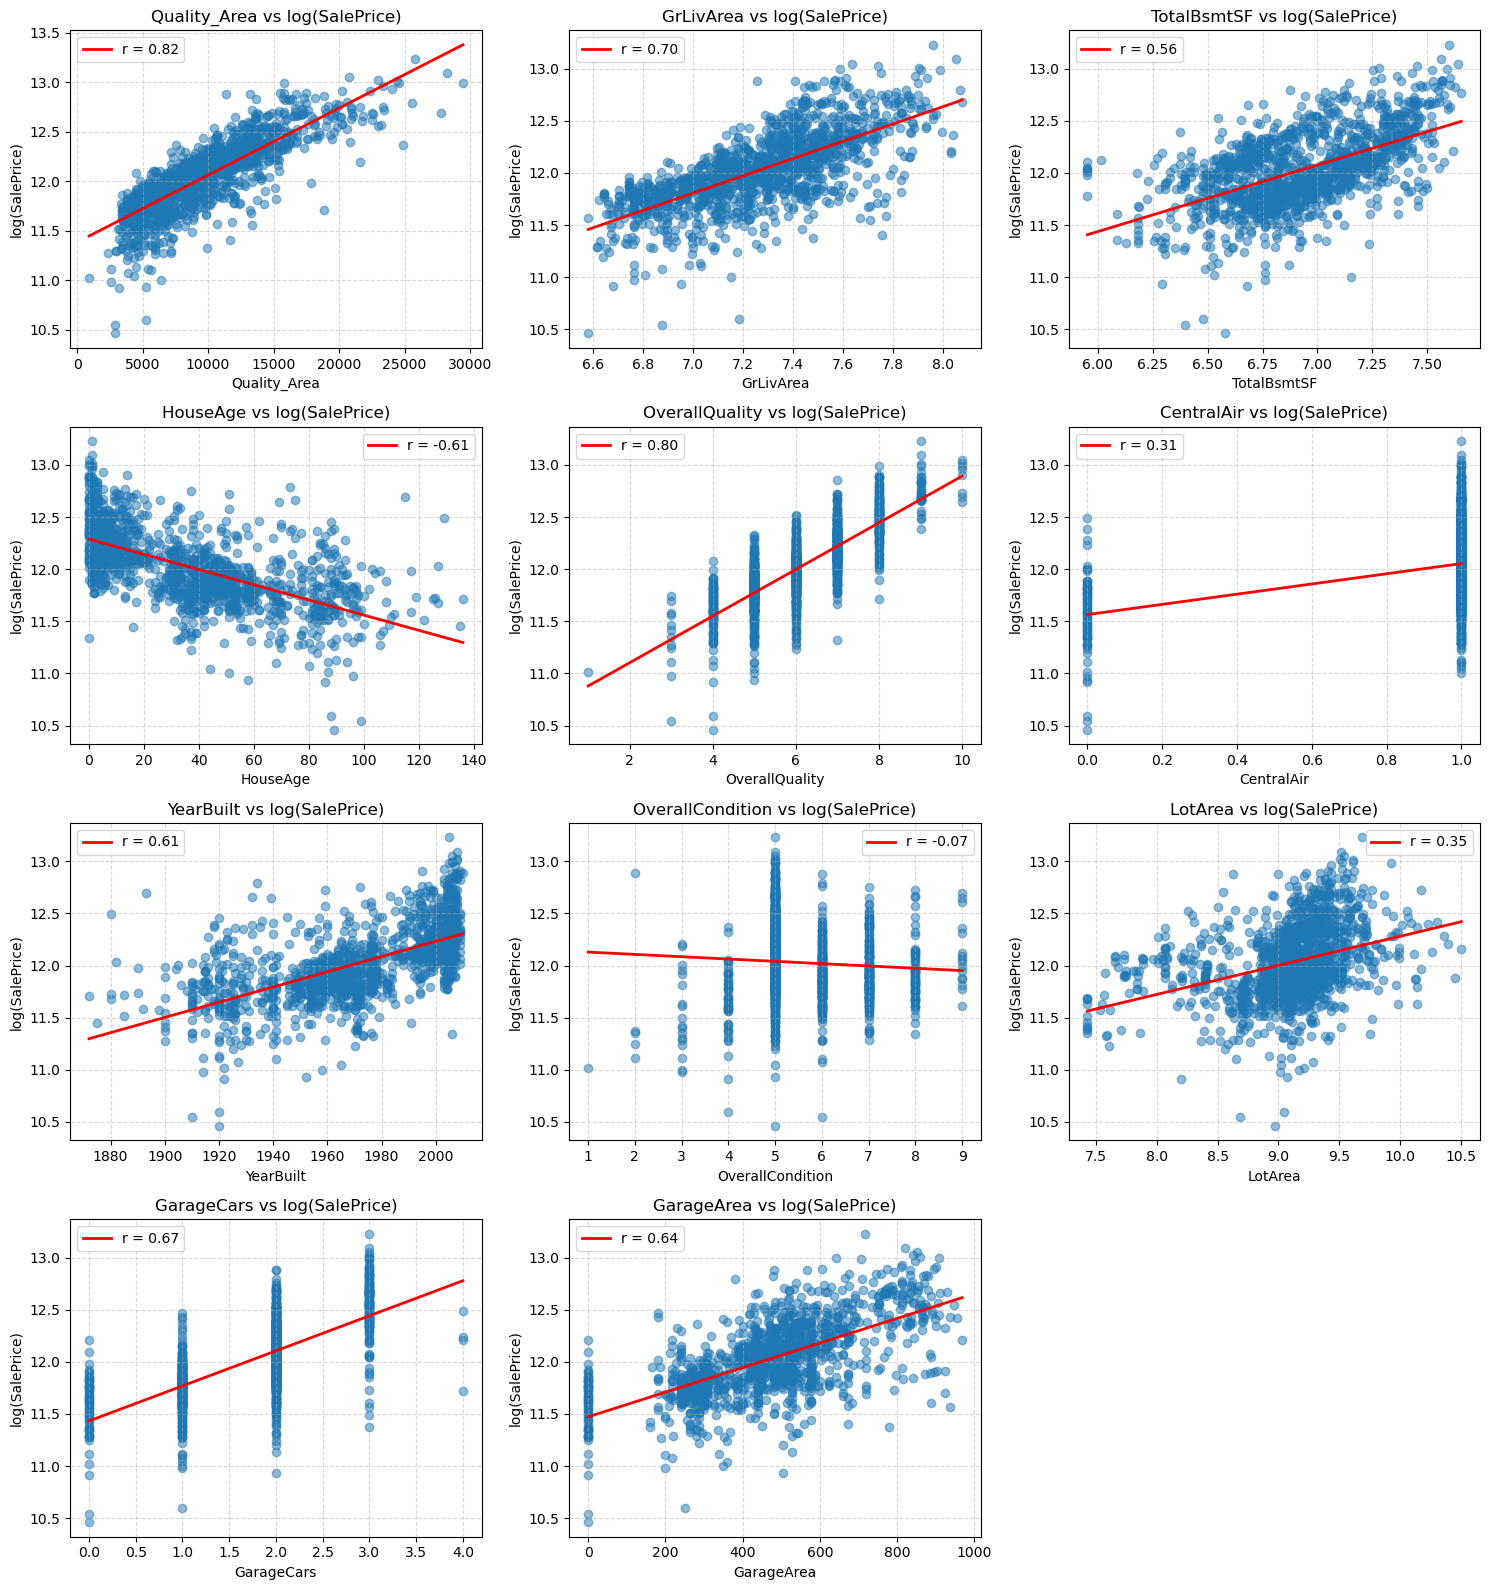


STEP 4: TRAINING FINAL MODEL
Performing 10-fold cross-validation...

Cross-Validation Results (10-Fold):
  - R²: 0.8754 ± 0.0251
  - MAE: 0.0912 ± 0.0068
  - MSE: 0.0161 ± 0.0037
  - RMSE: 0.1268

Splitting data into 90% training and 10% test sets...
  - Training set: (1202, 18)
  - Test set: (134, 18)

Training final linear regression model...
Model trained

Evaluating model on test set...

Test Set Results:
  - R²: 0.7895
  - MAE: 0.0994
  - MSE: 0.0205
  - RMSE: 0.1431


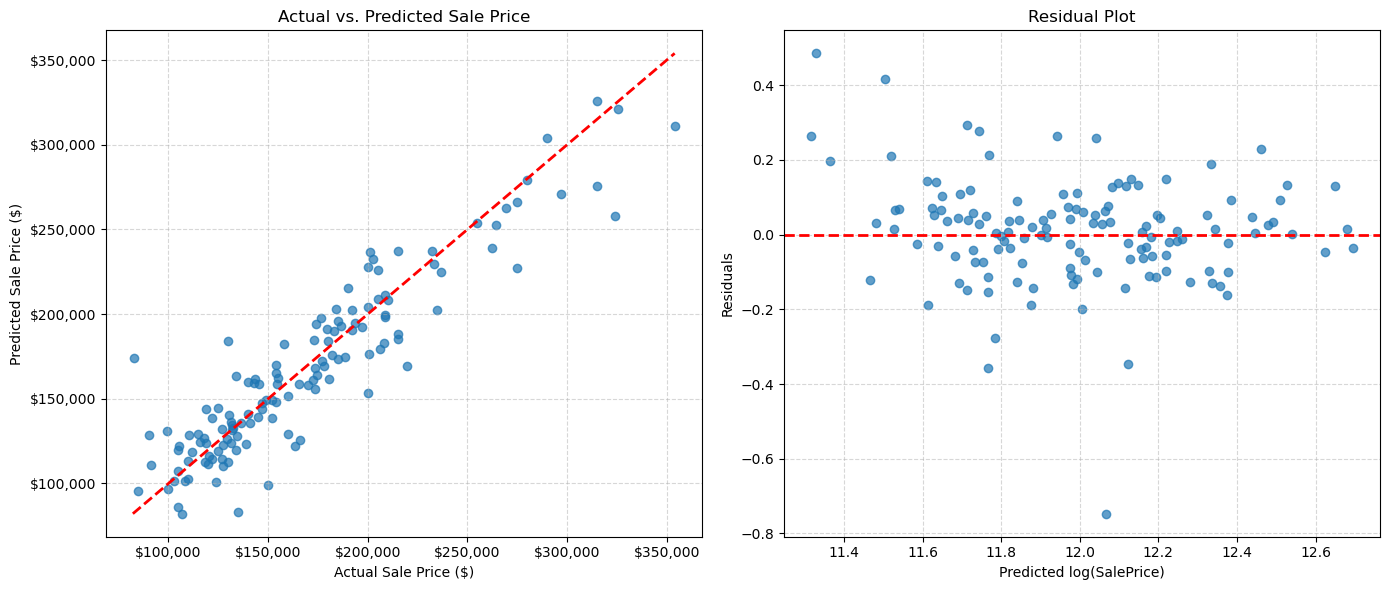


HOUSE PRICE PREDICTION MODEL COMPLETED SUCCESSFULLY


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# =============================================================================
# Simplified House Price Analysis Pipeline
# =============================================================================
class HousePriceAnalysis:
    def __init__(self):
        """Initialize the house price analysis pipeline"""
        self.df = None
        self.X = None
        self.y = None
        self.pipeline = None
        self.coef_df_sorted = None
        self.numeric_features = None
        self.categorical_features = None
        self.garage_dummy_cols = None
        self.preprocessor = None
        self.all_feature_names = None
        self.selected_features = None
        self.X_final = None
        self.scaler = None
        self.final_model = None
        
    def load_data(self, filepath):
        """Load house sales dataset from CSV file"""
        print("Loading data from", filepath)
        self.df = pd.read_csv(filepath)
        print(f"Dataset shape: {self.df.shape} (rows, columns)")
        return self.df
    
    def preprocess_data(self):
        """Clean and preprocess the data"""
        print("\nSTEP 1: DATA PREPROCESSING")
        print("Filling missing values in garage-related columns and alley...")
        
        # Fill missing garage values
        self.df["GarageArea"] = self.df["GarageArea"].fillna(
            self.df.groupby("GarageCars")["GarageArea"].transform("mean")
        )
        condition = (self.df["GarageArea"] == 0) & (self.df["GarageType"].isna())
        self.df.loc[condition, "GarageType"] = "No garage"
        self.df["Alley"] = self.df["Alley"].fillna("No Alley")
        
        print("Missing values report:")
        print("  - GarageArea:", self.df["GarageArea"].isna().sum())
        print("  - GarageType:", self.df["GarageType"].isna().sum())
        print("  - Alley:", self.df["Alley"].isna().sum())
        print("  - TotalBsmtSF:", self.df["TotalBsmtSF"].isna().sum())
        
        print("Filtering out rows with zero basement square footage...")
        print("  - Rows before filtering:", len(self.df))
        self.df = self.df[self.df["TotalBsmtSF"] != 0]
        print("  - Rows after filtering:", len(self.df))
        
        # Standardize SaleCondition
        print("Standardizing text in SaleCondition...")
        self.df['SaleCondition'] = self.df['SaleCondition'].str.lower().str.capitalize()
        self.df['SaleCondition'] = self.df['SaleCondition'].replace({"Abnorml": "Abnormal"})
        
        # Remove extreme outliers
        print("Removing extreme outliers...")
        for col in ['LotArea', 'GrLivArea', 'TotalBsmtSF', 'GarageArea']:
            before_count = len(self.df)
            lower_bound = self.df[col].quantile(0.01)
            upper_bound = self.df[col].quantile(0.99)
            self.df = self.df[(self.df[col] >= lower_bound) & (self.df[col] <= upper_bound)]
            removed = before_count - len(self.df)
            if removed > 0:
                print(f"  - Removed {removed} outliers from {col}")
        
        # Feature engineering
        print("Creating new engineered features...")
        self.df['HouseAge'] = self.df['YearSold'] - self.df['YearBuilt']
        self.df['TotalBath'] = self.df['FullBath'] + 0.5 * self.df['HalfBath']
        self.df = self.df.drop(columns=['FullBath', 'HalfBath'])
        print("  - Added: HouseAge, TotalBath")
        
        # Add new interaction terms
        print("Adding interaction terms for better model performance...")
        self.df['Quality_Area'] = self.df['OverallQuality'] * self.df['GrLivArea']
        self.df['Quality_Age'] = self.df['OverallQuality'] / (self.df['HouseAge'] + 1)  # Adding 1 to avoid division by zero
        print("  - Added: Quality_Area, Quality_Age")
        
        # Log transformation for skewed features
        print("Applying log transformation to skewed features...")
        skew_features = ['LotArea', 'GrLivArea', 'TotalBsmtSF', 'SalePrice']
        for feature in skew_features:
            self.df[feature] = np.log1p(self.df[feature])
        print("  - Transformed:", ", ".join(skew_features))
        
        # Manual encoding
        print("Performing manual encoding of categorical variables...")
        if 'Foundation' in self.df.columns:
            self.df = self.df.drop(columns=['Foundation'])
        self.df['CentralAir'] = self.df['CentralAir'].map({'Y': 1, 'N': 0})
        self.df['Street'] = self.df['Street'].map({'Pave': 1, 'Grvl': 0})
        
        garage_dummies = pd.get_dummies(self.df['GarageType'], prefix='GarageType')
        if 'GarageType_No garage' in garage_dummies.columns:
            garage_dummies = garage_dummies.drop(columns=['GarageType_No garage'])
        self.df = pd.concat([self.df, garage_dummies], axis=1)
        self.df = self.df.drop(columns=['GarageType'])
        
        print("Preprocessing completed successfully")
        
        # Prepare features and target
        print("Preparing features and target variable...")
        self.y = self.df['SalePrice']
        self.X = self.df.drop(columns=['SalePrice'])
        
        # Define feature groups
        self.garage_dummy_cols = [col for col in self.X.columns if col.startswith('GarageType_')]
        self.numeric_features = [
            'LotArea', 'GrLivArea', 'TotalBsmtSF', 'GarageArea',
            'YearBuilt', 'YearSold', 'HouseAge', 'OverallQuality', 'OverallCondition',
            'TotalBath', 'GarageCars', 'CentralAir', 'Street', 'Quality_Area', 'Quality_Age'
        ] + self.garage_dummy_cols
        
        self.categorical_features = [
            'Alley', 'LotType', 'BldgType', 'HouseStyle', 'SaleType', 'SaleCondition'
        ]
        
        print(f"  - Features prepared: {len(self.numeric_features)} numeric, {len(self.categorical_features)} categorical")
        print("Data preparation completed")
        
        # Plot correlation matrix
        self._plot_correlation_matrix()
        
    def build_feature_selection_pipeline(self):
        """Build and fit a Lasso pipeline for feature selection"""
        print("\nSTEP 2: FEATURE SELECTION")
        print("Building feature selection pipeline...")
        
        # Create preprocessor
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', RobustScaler(), self.numeric_features),
                ('cat', OneHotEncoder(drop='first'), self.categorical_features)
            ]
        )
        
        # Create pipeline with LassoCV
        self.pipeline = Pipeline(steps=[
            ('preprocessor', self.preprocessor),
            ('lasso', LassoCV(cv=5))
        ])
        
        print("Fitting Lasso model for feature selection...")
        self.pipeline.fit(self.X, self.y)
        print("Lasso model fitted")
        
        # Extract feature names and coefficients
        print("Extracting Lasso coefficients...")
        ohe = self.pipeline.named_steps['preprocessor'].named_transformers_['cat']
        cat_feature_names = ohe.get_feature_names_out(self.categorical_features)
        self.all_feature_names = self.numeric_features + list(cat_feature_names)
        
        lasso_coef = self.pipeline.named_steps['lasso'].coef_
        self.coef_df_sorted = pd.DataFrame({
            'Feature': self.all_feature_names,
            'Coefficient': lasso_coef
        })
        self.coef_df_sorted['AbsCoefficient'] = self.coef_df_sorted['Coefficient'].abs()
        self.coef_df_sorted = self.coef_df_sorted.sort_values(by='AbsCoefficient', ascending=False)
        
        print("Feature coefficients extracted and sorted")
        
        # Show top 10 features
        print("\nTop 10 most important features:")
        print(self.coef_df_sorted.head(10))
        
        # Plot all coefficients (both selected and unselected)
        self._plot_all_coefficients()
        
    def find_optimal_feature_set(self):
        """Find the optimal feature selection threshold"""
        print("\nSTEP 3: FINDING OPTIMAL FEATURE SET")
        print("Testing different threshold values for feature selection...")
        
        cv = KFold(n_splits=10, shuffle=True)
        threshold_values = np.arange(0, 0.15 + 0.01, 0.01)
        r2_cv_scores = []
        num_selected_features = []
        
        # Create progress indicator
        total_thresholds = len(threshold_values)
        
        for i, thr in enumerate(threshold_values):
            print(f"  - Testing threshold {thr:.2f} ({i+1}/{total_thresholds})...", end="")
            
            # Get features above threshold
            sf = self._get_selected_features(threshold=thr)
            if len(sf) == 0:
                print(f" No features selected; using all features instead.")
                sf = self.all_feature_names
            
            num_selected_features.append(len(sf))
            
            # Create and evaluate temporary model
            X_final_temp = self._create_selected_dataset(sf)
            cv_result = cross_validate(LinearRegression(), X_final_temp, self.y, cv=cv, scoring='r2')
            avg_r2 = np.mean(cv_result['test_score'])
            r2_cv_scores.append(avg_r2)
            
            print(f" R² = {avg_r2:.4f} with {len(sf)} features")
        
        # Plot R² vs. threshold and annotate with the number of selected features
        plt.figure(figsize=(10, 6))
        plt.scatter(threshold_values, r2_cv_scores, color='blue')
        plt.plot(threshold_values, r2_cv_scores, linestyle='--', color='red')
        for i, thr in enumerate(threshold_values):
            plt.text(thr, r2_cv_scores[i] + 0.002, f"n={num_selected_features[i]}", ha='center', va='bottom', fontsize=8)
        plt.xlabel("Threshold")
        plt.ylabel("Cross-Validated R²")
        plt.title("Threshold vs. Cross-Validated R²")
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        # Find best threshold
        best_index = np.argmax(r2_cv_scores)
        best_threshold = threshold_values[best_index]
        print(f"Best threshold found: {best_threshold:.4f} with R² = {r2_cv_scores[best_index]:.4f}")
        
        # Select features with best threshold
        self.selected_features = self._get_selected_features(threshold=best_threshold)
        if len(self.selected_features) == 0:
            print("No feature met the best threshold; using all features instead.")
            self.selected_features = self.all_feature_names
        
        # Print ALL selected features, not just the top 10
        print(f"Selected {len(self.selected_features)} features:")
        for feature in self.selected_features:
            print(f"  - {feature}")
        
        # Create final selected dataset
        self.X_final = self._create_selected_dataset(self.selected_features)
        print(f"Final dataset created with shape: {self.X_final.shape}")
        
        # Plot ALL selected numeric features, not just the top 5
        self._plot_selected_features()
        
    def train_final_model(self):
        """Train and evaluate the final linear regression model"""
        print("\nSTEP 4: TRAINING FINAL MODEL")
        
        # Cross-validation
        print("Performing 10-fold cross-validation...")
        cv = KFold(n_splits=10, shuffle=True)
        cv_results = cross_validate(LinearRegression(), self.X_final, self.y, cv=cv, scoring={
            'R2': 'r2',
            'MAE': 'neg_mean_absolute_error',
            'MSE': 'neg_mean_squared_error'
        })
        
        print("\nCross-Validation Results (10-Fold):")
        print(f"  - R²: {np.mean(cv_results['test_R2']):.4f} ± {np.std(cv_results['test_R2']):.4f}")
        print(f"  - MAE: {-np.mean(cv_results['test_MAE']):.4f} ± {np.std(cv_results['test_MAE']):.4f}")
        print(f"  - MSE: {-np.mean(cv_results['test_MSE']):.4f} ± {np.std(cv_results['test_MSE']):.4f}")
        print(f"  - RMSE: {np.sqrt(-np.mean(cv_results['test_MSE'])):.4f}")
        
        # Split into train/test
        print("\nSplitting data into 90% training and 10% test sets...")
        X_train, X_test, y_train, y_test = train_test_split(
            self.X_final,
            self.y.loc[self.X_final.index],
            test_size=0.1
        )
        print(f"  - Training set: {X_train.shape}")
        print(f"  - Test set: {X_test.shape}")
        
        # Train model
        print("\nTraining final linear regression model...")
        self.final_model = LinearRegression()
        self.final_model.fit(X_train, y_train)
        print("Model trained")
        
        # Evaluate on test set
        print("\nEvaluating model on test set...")
        y_pred = self.final_model.predict(X_test)
        test_r2 = r2_score(y_test, y_pred)
        test_mae = mean_absolute_error(y_test, y_pred)
        test_mse = mean_squared_error(y_test, y_pred)
        test_rmse = np.sqrt(test_mse)
        
        print("\nTest Set Results:")
        print(f"  - R²: {test_r2:.4f}")
        print(f"  - MAE: {test_mae:.4f}")
        print(f"  - MSE: {test_mse:.4f}")
        print(f"  - RMSE: {test_rmse:.4f}")
        
        # Plot results
        self._plot_prediction_results(y_test, y_pred)
        
        print("\nHOUSE PRICE PREDICTION MODEL COMPLETED SUCCESSFULLY")
        
    def _get_selected_features(self, threshold):
        """Helper method to get features with coefficients above threshold"""
        selected = self.coef_df_sorted.loc[self.coef_df_sorted['AbsCoefficient'] > threshold, 'Feature'].tolist()
        return selected
    
    def _create_selected_dataset(self, selected_features):
        """Helper method to create dataset with only selected features"""
        X_transformed = self.preprocessor.transform(self.X)
        X_transformed_df = pd.DataFrame(X_transformed, columns=self.all_feature_names, index=self.X.index)
        X_selected = X_transformed_df[selected_features].copy()
        continuous_cols = [col for col in selected_features if col in self.numeric_features]
        scaler = RobustScaler()
        if continuous_cols:
            X_selected[continuous_cols] = scaler.fit_transform(X_selected[continuous_cols])
        return X_selected
    
    def _plot_correlation_matrix(self):
        """Plot correlation matrix for numeric features"""
        print("Generating correlation matrix heatmap...")
        # Select numeric features plus target variable
        corr_features = [col for col in self.numeric_features if col in self.df.columns] + ['SalePrice']
        
        # Calculate correlation matrix
        corr_matrix = self.df[corr_features].corr()
        
        # Plot heatmap with correlation values
        plt.figure(figsize=(14, 12))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Create upper triangle mask
        sns.heatmap(corr_matrix, 
                   annot=True,  # Show correlation values in cells
                   fmt=".2f",   # Format correlation values to 2 decimal places
                   cmap='viridis', 
                   mask=mask,   # Only show lower triangle
                   linewidths=0.5,
                   vmin=-1, vmax=1)
        plt.title("Correlation Matrix for Numeric Features", fontsize=16)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # Show top correlations with SalePrice
        price_corr = corr_matrix['SalePrice'].abs().sort_values(ascending=False)
        print("\nTop correlations with SalePrice:")
        print(price_corr.head(10))
    
    def _plot_all_coefficients(self):
        """Plot all Lasso coefficients (selected and unselected)"""
        print("Plotting all feature coefficients (selected and unselected)...")
        
        # Sort by absolute coefficient value for better visualization
        sorted_by_abs_value = self.coef_df_sorted.sort_values(by='AbsCoefficient', ascending=True)
        
        plt.figure(figsize=(12, max(8, len(sorted_by_abs_value) * 0.25)))  # Dynamic height based on number of features
        
        # Plot horizontal bar chart with coefficients
        bars = plt.barh(sorted_by_abs_value['Feature'], sorted_by_abs_value['Coefficient'])
        
        # Color positive and negative coefficients differently
        for i, bar in enumerate(bars):
            if sorted_by_abs_value.iloc[i]['Coefficient'] < 0:
                bar.set_color('red')
            else:
                bar.set_color('green')
                
        plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        plt.xlabel("Coefficient Value", fontsize=12)
        plt.ylabel("Feature", fontsize=12)
        plt.title("All Lasso Model Coefficients for House Price Prediction (Selected and Unselected)", fontsize=14)
        plt.grid(axis='x', linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Print coefficient stats
        zero_coefs = len(sorted_by_abs_value[sorted_by_abs_value['Coefficient'] == 0])
        non_zero_coefs = len(sorted_by_abs_value) - zero_coefs
        print(f"Total features: {len(self.all_feature_names)}")
        print(f"Features with non-zero coefficients: {non_zero_coefs}")
        print(f"Features eliminated by Lasso: {zero_coefs}")
        
    def _plot_selected_features(self):
        """Plot scatter plots for ALL selected numeric features"""
        # Get all selected numeric features
        plot_features = [feat for feat in self.selected_features if feat in self.numeric_features]
        
        if len(plot_features) > 0:
            print(f"\nCreating scatter plots for ALL {len(plot_features)} selected numeric features...")
            
            n_features = len(plot_features)
            n_cols = min(3, n_features)
            n_rows = int(np.ceil(n_features / n_cols))
            
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
            if n_features == 1:
                axes = [axes]
            else:
                axes = np.array(axes).flatten()
                
            for i, feature in enumerate(plot_features):
                ax = axes[i]
                ax.scatter(self.X[feature], self.y, alpha=0.5)
                ax.set_xlabel(feature)
                ax.set_ylabel("log(SalePrice)")
                ax.set_title(f"{feature} vs log(SalePrice)")
                
                # Add trend line
                slope, intercept = np.polyfit(self.X[feature], self.y, 1)
                x_vals = np.linspace(self.X[feature].min(), self.X[feature].max(), 100)
                y_vals = slope * x_vals + intercept
                ax.plot(x_vals, y_vals, color='red', linewidth=2, label=f'r = {np.corrcoef(self.X[feature], self.y)[0,1]:.2f}')
                ax.legend()
                ax.grid(True, linestyle='--', alpha=0.5)
                
            # Remove extra subplots if necessary
            for j in range(i + 1, len(axes)):
                fig.delaxes(axes[j])
                
            plt.tight_layout()
            plt.show()
        else:
            print("No suitable numeric features selected for scatter plotting.")
            
    def _plot_prediction_results(self, y_test, y_pred):
        """Plot actual vs predicted prices"""
        # Convert back to real scale
        y_test_real = np.expm1(y_test)
        y_pred_real = np.expm1(y_pred)
        
        # Calculate residuals
        residuals = y_test - y_pred
        
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Plot 1: Actual vs Predicted
        ax1.scatter(y_test_real, y_pred_real, alpha=0.7)
        min_val = min(y_test_real.min(), y_pred_real.min())
        max_val = max(y_test_real.max(), y_pred_real.max())
        ax1.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2)
        ax1.set_xlabel("Actual Sale Price ($)")
        ax1.set_ylabel("Predicted Sale Price ($)")
        ax1.set_title("Actual vs. Predicted Sale Price")
        ax1.grid(True, linestyle='--', alpha=0.5)
        
        # Format axes with dollar signs
        import matplotlib.ticker as mtick
        ax1.xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
        ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
        
        # Plot 2: Residuals
        ax2.scatter(y_pred, residuals, alpha=0.7)
        ax2.axhline(y=0, color='red', linestyle='--', linewidth=2)
        ax2.set_xlabel("Predicted log(SalePrice)")
        ax2.set_ylabel("Residuals")
        ax2.set_title("Residual Plot")
        ax2.grid(True, linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.show()
        
# =============================================================================
# Main Execution Block
# =============================================================================
if __name__ == "__main__":
    # Create instance of the pipeline
    house_model = HousePriceAnalysis()
    
    # Run the entire pipeline
    house_model.load_data("dataset.csv")
    house_model.preprocess_data()
    house_model.build_feature_selection_pipeline()
    house_model.find_optimal_feature_set()
    house_model.train_final_model()

Loading data from dataset.csv
Dataset shape: (1460, 22) (rows, columns)

STEP 1: DATA PREPROCESSING
Filling missing values in garage-related columns and alley...
Missing values report:
  - GarageArea: 0
  - GarageType: 0
  - Alley: 0
Filtering out rows with zero basement square footage...
  - Rows before filtering: 1460
  - Rows after filtering: 1423
Standardizing text in SaleCondition...
Removing extreme outliers...
  - Removed 22 outliers from LotArea
  - Removed 28 outliers from GrLivArea
  - Removed 23 outliers from TotalBsmtSF
  - Removed 14 outliers from GarageArea
Creating new engineered features...
  - Added: HouseAge, TotalBath
Adding interaction terms for better model performance...
  - Added: Quality_Area, Quality_Age
Applying log transformation to skewed features...
  - Transformed: LotArea, GrLivArea, TotalBsmtSF, SalePrice
Performing manual encoding of categorical variables...
Preprocessing completed successfully
Preparing features and target variable...
  - Features prep

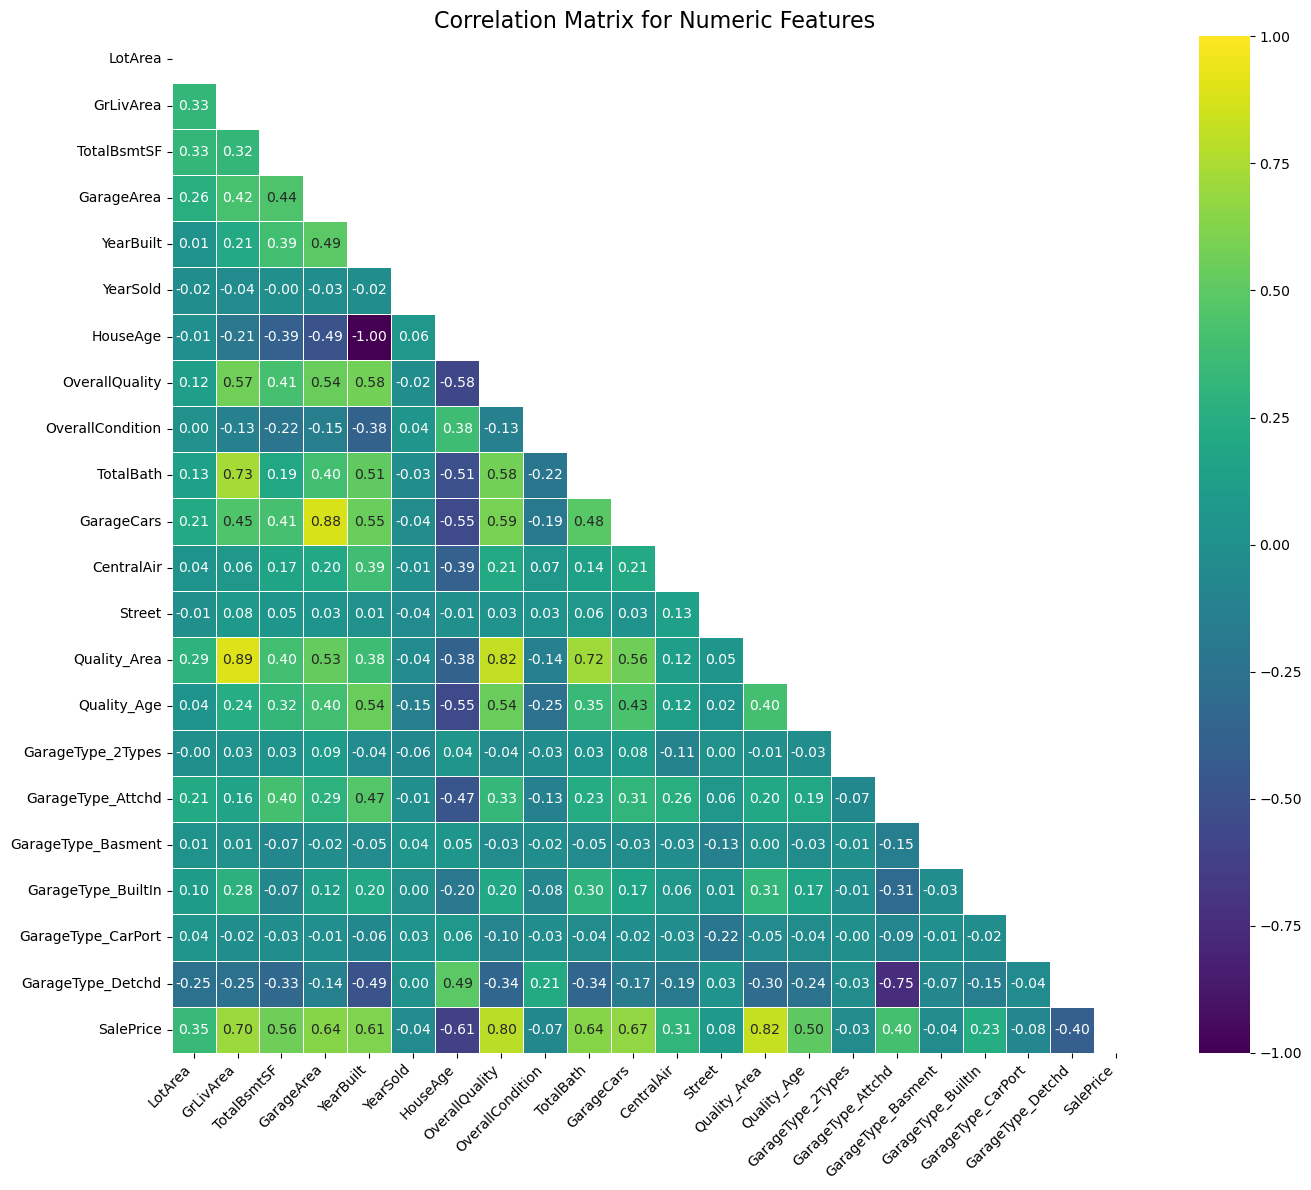


Top correlations with SalePrice:
SalePrice         1.000000
Quality_Area      0.822120
OverallQuality    0.796342
GrLivArea         0.696035
GarageCars        0.665252
GarageArea        0.638070
TotalBath         0.635326
HouseAge          0.611511
YearBuilt         0.610757
TotalBsmtSF       0.561778
Name: SalePrice, dtype: float64

STEP 2: FEATURE SELECTION
Building feature selection pipeline...
Fitting Lasso model for feature selection...
Lasso model fitted
Extracting Lasso coefficients...
Feature coefficients extracted and sorted

Top 10 most important features:
                 Feature  Coefficient  AbsCoefficient
13          Quality_Area     0.137129        0.137129
1              GrLivArea     0.096382        0.096382
2            TotalBsmtSF     0.082686        0.082686
6               HouseAge    -0.081429        0.081429
44          SaleType_New     0.080118        0.080118
7         OverallQuality     0.078607        0.078607
11            CentralAir     0.074594        0.0

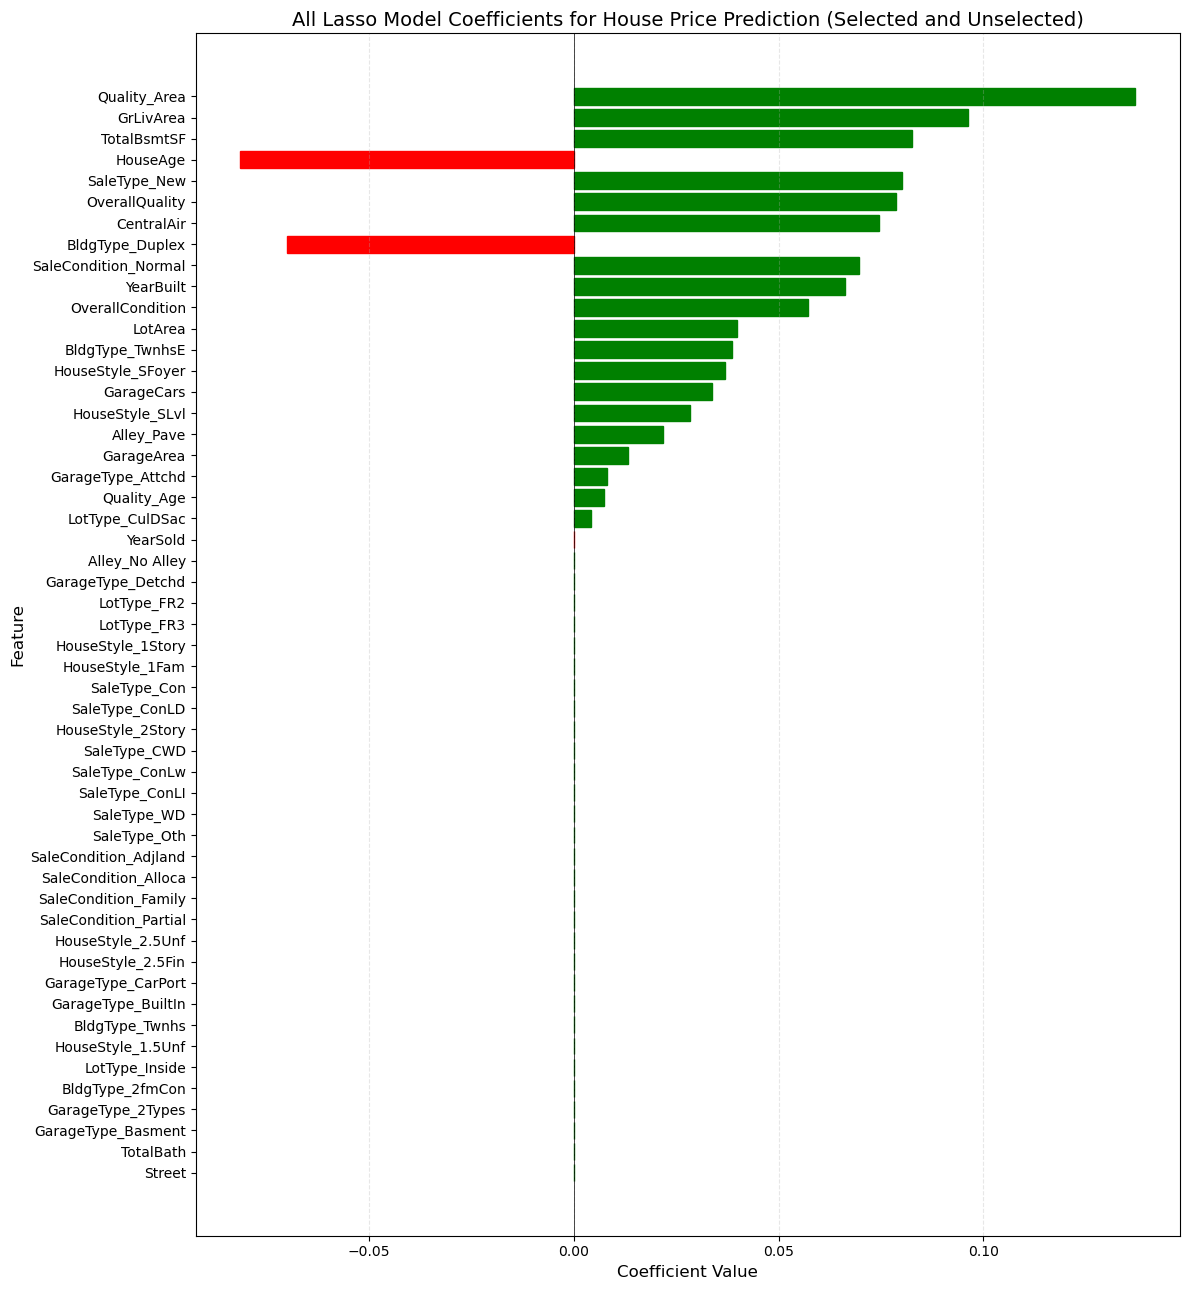

Total features: 52
Features with non-zero coefficients: 22
Features eliminated by Lasso: 30

STEP 3: FINDING OPTIMAL FEATURE SET
Testing different threshold values for feature selection...
  - Testing threshold 0.00 (1/16)... R² = 0.8742 with 22 features
  - Testing threshold 0.01 (2/16)... R² = 0.8744 with 18 features
  - Testing threshold 0.02 (3/16)... R² = 0.8756 with 17 features
  - Testing threshold 0.03 (4/16)... R² = 0.8730 with 15 features
  - Testing threshold 0.04 (5/16)... R² = 0.8566 with 11 features
  - Testing threshold 0.05 (6/16)... R² = 0.8580 with 11 features
  - Testing threshold 0.06 (7/16)... R² = 0.8327 with 10 features
  - Testing threshold 0.07 (8/16)... R² = 0.8265 with 8 features
  - Testing threshold 0.08 (9/16)... R² = 0.8087 with 5 features
  - Testing threshold 0.09 (10/16)... R² = 0.6790 with 2 features
  - Testing threshold 0.10 (11/16)... R² = 0.6722 with 1 features
  - Testing threshold 0.11 (12/16)... R² = 0.6669 with 1 features
  - Testing threshold

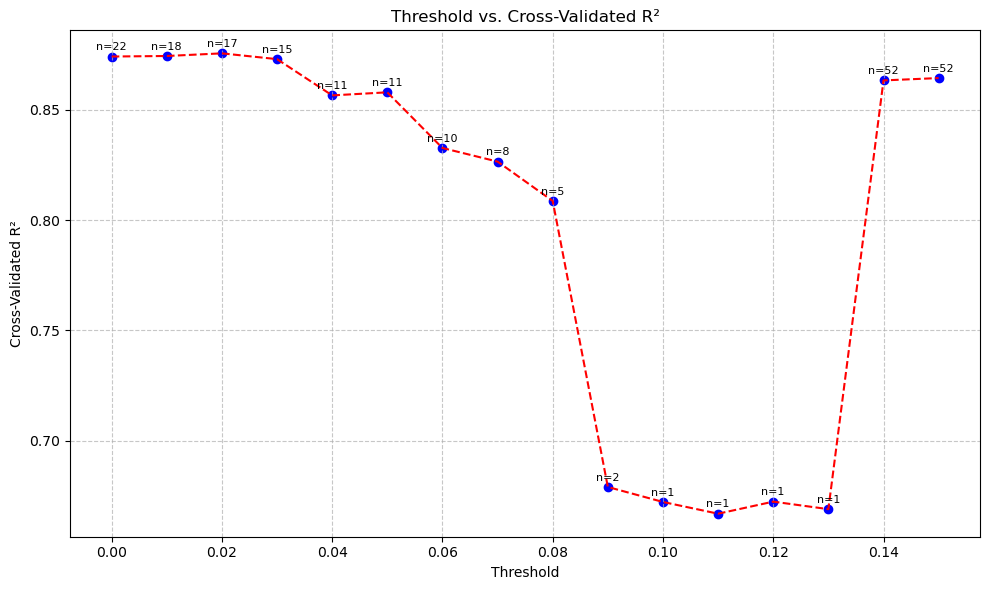

Best threshold found: 0.0200 with R² = 0.8756
  - Adding mandatory feature: TotalBath
  - Adding mandatory feature: GarageArea
Selected 19 features:
  - Quality_Area
  - GrLivArea
  - TotalBsmtSF
  - HouseAge
  - SaleType_New
  - OverallQuality
  - CentralAir
  - BldgType_Duplex
  - SaleCondition_Normal
  - YearBuilt
  - OverallCondition
  - LotArea
  - BldgType_TwnhsE
  - HouseStyle_SFoyer
  - GarageCars
  - HouseStyle_SLvl
  - Alley_Pave
  - TotalBath
  - GarageArea
Final dataset created with shape: (1336, 19)

Creating scatter plots for ALL 12 selected numeric features...


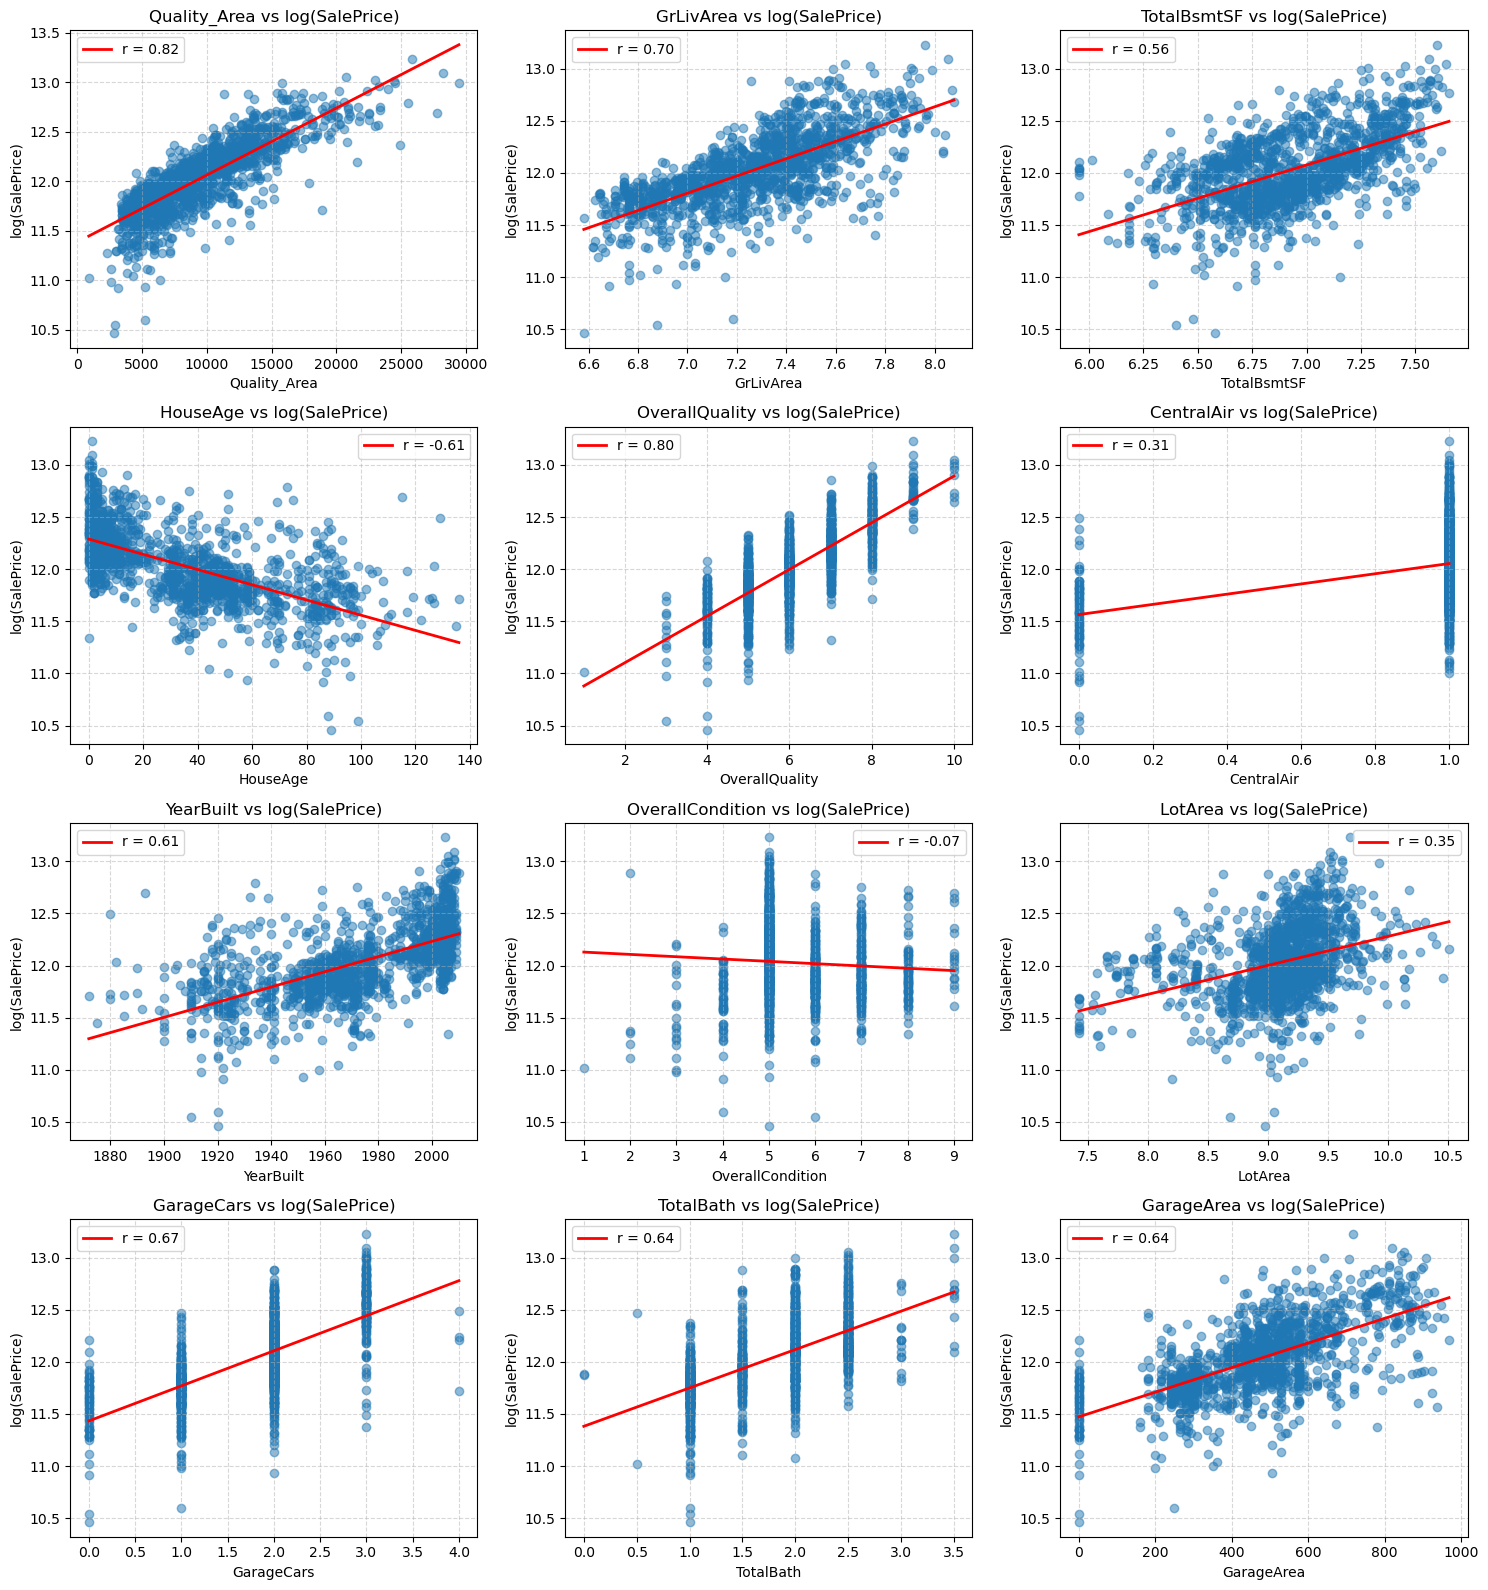


STEP 4: TRAINING FINAL MODEL
Performing 10-fold cross-validation...

Cross-Validation Results (10-Fold):
  - R²: 0.8729 ± 0.0283
  - MAE: 0.0914 ± 0.0044
  - MSE: 0.0161 ± 0.0027
  - RMSE: 0.1270

Splitting data into 90% training and 10% test sets...
  - Training set: (1202, 19)
  - Test set: (134, 19)

Training final linear regression model...
Model trained

Evaluating model on test set...

Test Set Results:
  - R²: 0.8915
  - MAE: 0.0956
  - MSE: 0.0163
  - RMSE: 0.1276


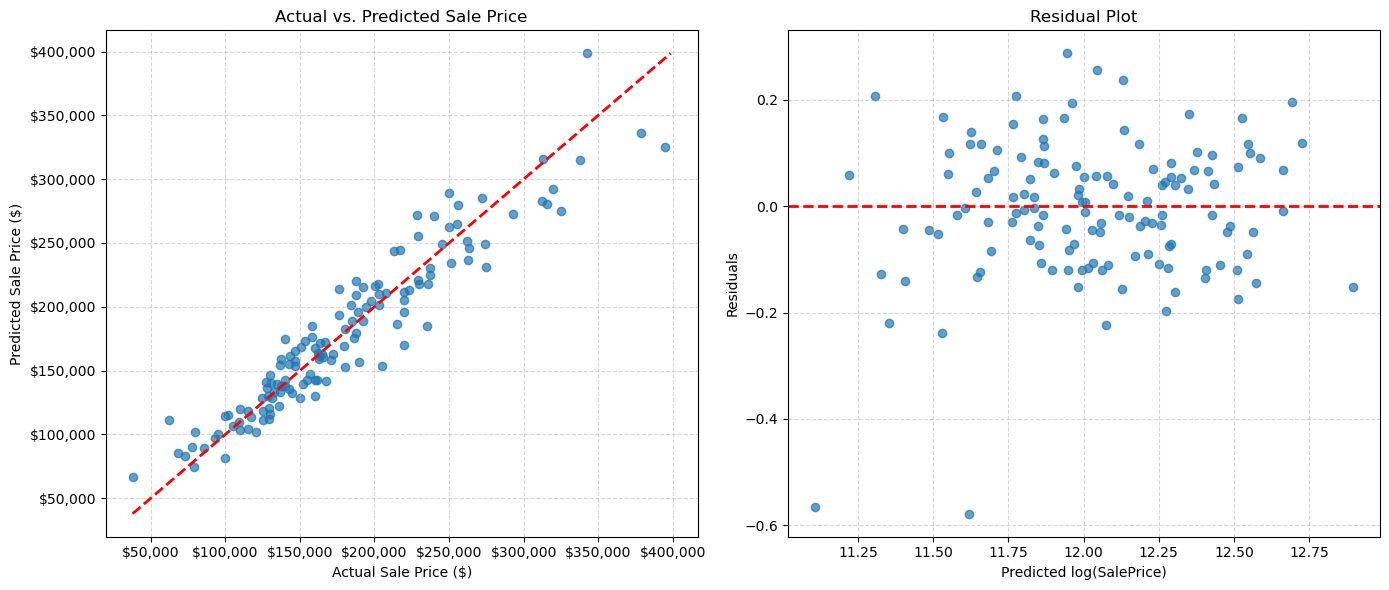


HOUSE PRICE PREDICTION MODEL COMPLETED SUCCESSFULLY


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# =============================================================================
# Simplified House Price Analysis Pipeline
# =============================================================================
class HousePriceAnalysis:
    def __init__(self):
        """Initialize the house price analysis pipeline"""
        self.df = None
        self.X = None
        self.y = None
        self.pipeline = None
        self.coef_df_sorted = None
        self.numeric_features = None
        self.categorical_features = None
        self.garage_dummy_cols = None
        self.preprocessor = None
        self.all_feature_names = None
        self.selected_features = None
        self.X_final = None
        self.scaler = None
        self.final_model = None
        
    def load_data(self, filepath):
        """Load house sales dataset from CSV file"""
        print("Loading data from", filepath)
        self.df = pd.read_csv(filepath)
        print(f"Dataset shape: {self.df.shape} (rows, columns)")
        return self.df
    
    def preprocess_data(self):
        """Clean and preprocess the data"""
        print("\nSTEP 1: DATA PREPROCESSING")
        print("Filling missing values in garage-related columns and alley...")
        
        # Fill missing garage values
        self.df["GarageArea"] = self.df["GarageArea"].fillna(
            self.df.groupby("GarageCars")["GarageArea"].transform("mean")
        )
        condition = (self.df["GarageArea"] == 0) & (self.df["GarageType"].isna())
        self.df.loc[condition, "GarageType"] = "No garage"
        self.df["Alley"] = self.df["Alley"].fillna("No Alley")
        
        print("Missing values report:")
        print("  - GarageArea:", self.df["GarageArea"].isna().sum())
        print("  - GarageType:", self.df["GarageType"].isna().sum())
        print("  - Alley:", self.df["Alley"].isna().sum())
        
        print("Filtering out rows with zero basement square footage...")
        print("  - Rows before filtering:", len(self.df))
        self.df = self.df[self.df["TotalBsmtSF"] != 0]
        print("  - Rows after filtering:", len(self.df))
        
        # Standardize SaleCondition
        print("Standardizing text in SaleCondition...")
        self.df['SaleCondition'] = self.df['SaleCondition'].str.lower().str.capitalize()
        self.df['SaleCondition'] = self.df['SaleCondition'].replace({"Abnorml": "Abnormal"})
        
        # Remove extreme outliers
        print("Removing extreme outliers...")
        for col in ['LotArea', 'GrLivArea', 'TotalBsmtSF', 'GarageArea']:
            before_count = len(self.df)
            lower_bound = self.df[col].quantile(0.01)
            upper_bound = self.df[col].quantile(0.99)
            self.df = self.df[(self.df[col] >= lower_bound) & (self.df[col] <= upper_bound)]
            removed = before_count - len(self.df)
            if removed > 0:
                print(f"  - Removed {removed} outliers from {col}")
        
        # Feature engineering
        print("Creating new engineered features...")
        self.df['HouseAge'] = self.df['YearSold'] - self.df['YearBuilt']
        self.df['TotalBath'] = self.df['FullBath'] + 0.5 * self.df['HalfBath']
        self.df = self.df.drop(columns=['FullBath', 'HalfBath'])
        print("  - Added: HouseAge, TotalBath")
        
        # Add new interaction terms
        print("Adding interaction terms for better model performance...")
        self.df['Quality_Area'] = self.df['OverallQuality'] * self.df['GrLivArea']
        self.df['Quality_Age'] = self.df['OverallQuality'] / (self.df['HouseAge'] + 1)  # Adding 1 to avoid division by zero
        print("  - Added: Quality_Area, Quality_Age")
        
        # Log transformation for skewed features
        print("Applying log transformation to skewed features...")
        skew_features = ['LotArea', 'GrLivArea', 'TotalBsmtSF', 'SalePrice']
        for feature in skew_features:
            self.df[feature] = np.log1p(self.df[feature])
        print("  - Transformed:", ", ".join(skew_features))
        
        # Manual encoding
        print("Performing manual encoding of categorical variables...")
        if 'Foundation' in self.df.columns:
            self.df = self.df.drop(columns=['Foundation'])
        self.df['CentralAir'] = self.df['CentralAir'].map({'Y': 1, 'N': 0})
        self.df['Street'] = self.df['Street'].map({'Pave': 1, 'Grvl': 0})
        
        garage_dummies = pd.get_dummies(self.df['GarageType'], prefix='GarageType')
        if 'GarageType_No garage' in garage_dummies.columns:
            garage_dummies = garage_dummies.drop(columns=['GarageType_No garage'])
        self.df = pd.concat([self.df, garage_dummies], axis=1)
        self.df = self.df.drop(columns=['GarageType'])
        
        print("Preprocessing completed successfully")
        
        # Prepare features and target
        print("Preparing features and target variable...")
        self.y = self.df['SalePrice']
        self.X = self.df.drop(columns=['SalePrice'])
        
        # Define feature groups
        self.garage_dummy_cols = [col for col in self.X.columns if col.startswith('GarageType_')]
        self.numeric_features = [
            'LotArea', 'GrLivArea', 'TotalBsmtSF', 'GarageArea',
            'YearBuilt', 'YearSold', 'HouseAge', 'OverallQuality', 'OverallCondition',
            'TotalBath', 'GarageCars', 'CentralAir', 'Street', 'Quality_Area', 'Quality_Age'
        ] + self.garage_dummy_cols
        
        self.categorical_features = [
            'Alley', 'LotType', 'BldgType', 'HouseStyle', 'SaleType', 'SaleCondition'
        ]
        
        print(f"  - Features prepared: {len(self.numeric_features)} numeric, {len(self.categorical_features)} categorical")
        print("Data preparation completed")
        
        # Plot correlation matrix
        self._plot_correlation_matrix()
        
    def build_feature_selection_pipeline(self):
        """Build and fit a Lasso pipeline for feature selection"""
        print("\nSTEP 2: FEATURE SELECTION")
        print("Building feature selection pipeline...")
        
        # Create preprocessor
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', RobustScaler(), self.numeric_features),
                ('cat', OneHotEncoder(drop='first'), self.categorical_features)
            ]
        )
        
        # Create pipeline with LassoCV
        self.pipeline = Pipeline(steps=[
            ('preprocessor', self.preprocessor),
            ('lasso', LassoCV(cv=5))
        ])
        
        print("Fitting Lasso model for feature selection...")
        self.pipeline.fit(self.X, self.y)
        print("Lasso model fitted")
        
        # Extract feature names and coefficients
        print("Extracting Lasso coefficients...")
        ohe = self.pipeline.named_steps['preprocessor'].named_transformers_['cat']
        cat_feature_names = ohe.get_feature_names_out(self.categorical_features)
        self.all_feature_names = self.numeric_features + list(cat_feature_names)
        
        lasso_coef = self.pipeline.named_steps['lasso'].coef_
        self.coef_df_sorted = pd.DataFrame({
            'Feature': self.all_feature_names,
            'Coefficient': lasso_coef
        })
        self.coef_df_sorted['AbsCoefficient'] = self.coef_df_sorted['Coefficient'].abs()
        self.coef_df_sorted = self.coef_df_sorted.sort_values(by='AbsCoefficient', ascending=False)
        
        print("Feature coefficients extracted and sorted")
        
        # Show top 10 features
        print("\nTop 10 most important features:")
        print(self.coef_df_sorted.head(10))
        
        # Plot all coefficients (both selected and unselected)
        self._plot_all_coefficients()
        
    def find_optimal_feature_set(self):
        """Find the optimal feature selection threshold"""
        print("\nSTEP 3: FINDING OPTIMAL FEATURE SET")
        print("Testing different threshold values for feature selection...")
        
        cv = KFold(n_splits=10, shuffle=True)
        threshold_values = np.arange(0, 0.15 + 0.01, 0.01)
        r2_cv_scores = []
        num_selected_features = []
        
        # Create progress indicator
        total_thresholds = len(threshold_values)
        
        for i, thr in enumerate(threshold_values):
            print(f"  - Testing threshold {thr:.2f} ({i+1}/{total_thresholds})...", end="")
            
            # Get features above threshold
            sf = self._get_selected_features(threshold=thr)
            if len(sf) == 0:
                print(f" No features selected; using all features instead.")
                sf = self.all_feature_names
            
            num_selected_features.append(len(sf))
            
            # Create and evaluate temporary model
            X_final_temp = self._create_selected_dataset(sf)
            cv_result = cross_validate(LinearRegression(), X_final_temp, self.y, cv=cv, scoring='r2')
            avg_r2 = np.mean(cv_result['test_score'])
            r2_cv_scores.append(avg_r2)
            
            print(f" R² = {avg_r2:.4f} with {len(sf)} features")
        
        # Plot R² vs. threshold and annotate with the number of selected features
        plt.figure(figsize=(10, 6))
        plt.scatter(threshold_values, r2_cv_scores, color='blue')
        plt.plot(threshold_values, r2_cv_scores, linestyle='--', color='red')
        for i, thr in enumerate(threshold_values):
            plt.text(thr, r2_cv_scores[i] + 0.002, f"n={num_selected_features[i]}", ha='center', va='bottom', fontsize=8)
        plt.xlabel("Threshold")
        plt.ylabel("Cross-Validated R²")
        plt.title("Threshold vs. Cross-Validated R²")
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        # Find best threshold
        best_index = np.argmax(r2_cv_scores)
        best_threshold = threshold_values[best_index]
        print(f"Best threshold found: {best_threshold:.4f} with R² = {r2_cv_scores[best_index]:.4f}")
        
        # Select features with best threshold
        self.selected_features = self._get_selected_features(threshold=best_threshold)
        if len(self.selected_features) == 0:
            print("No feature met the best threshold; using all features instead.")
            self.selected_features = self.all_feature_names
        
        # Ensure mandatory features are included
        for mandatory in ['TotalBath', 'GarageArea']:
            if mandatory not in self.selected_features:
                print(f"  - Adding mandatory feature: {mandatory}")
                self.selected_features.append(mandatory)
        
        # Print ALL selected features, not just the top 10
        print(f"Selected {len(self.selected_features)} features:")
        for feature in self.selected_features:
            print(f"  - {feature}")
        
        # Create final selected dataset
        self.X_final = self._create_selected_dataset(self.selected_features)
        print(f"Final dataset created with shape: {self.X_final.shape}")
        
        # Plot ALL selected numeric features, not just the top 5
        self._plot_selected_features()
        
    def train_final_model(self):
        """Train and evaluate the final linear regression model"""
        print("\nSTEP 4: TRAINING FINAL MODEL")
        
        # Cross-validation
        print("Performing 10-fold cross-validation...")
        cv = KFold(n_splits=10, shuffle=True)
        cv_results = cross_validate(LinearRegression(), self.X_final, self.y, cv=cv, scoring={
            'R2': 'r2',
            'MAE': 'neg_mean_absolute_error',
            'MSE': 'neg_mean_squared_error'
        })
        
        print("\nCross-Validation Results (10-Fold):")
        print(f"  - R²: {np.mean(cv_results['test_R2']):.4f} ± {np.std(cv_results['test_R2']):.4f}")
        print(f"  - MAE: {-np.mean(cv_results['test_MAE']):.4f} ± {np.std(cv_results['test_MAE']):.4f}")
        print(f"  - MSE: {-np.mean(cv_results['test_MSE']):.4f} ± {np.std(cv_results['test_MSE']):.4f}")
        print(f"  - RMSE: {np.sqrt(-np.mean(cv_results['test_MSE'])):.4f}")
        
        # Split into train/test
        print("\nSplitting data into 90% training and 10% test sets...")
        X_train, X_test, y_train, y_test = train_test_split(
            self.X_final,
            self.y.loc[self.X_final.index],
            test_size=0.1
        )
        print(f"  - Training set: {X_train.shape}")
        print(f"  - Test set: {X_test.shape}")
        
        # Train model
        print("\nTraining final linear regression model...")
        self.final_model = LinearRegression()
        self.final_model.fit(X_train, y_train)
        print("Model trained")
        
        # Evaluate on test set
        print("\nEvaluating model on test set...")
        y_pred = self.final_model.predict(X_test)
        test_r2 = r2_score(y_test, y_pred)
        test_mae = mean_absolute_error(y_test, y_pred)
        test_mse = mean_squared_error(y_test, y_pred)
        test_rmse = np.sqrt(test_mse)
        
        print("\nTest Set Results:")
        print(f"  - R²: {test_r2:.4f}")
        print(f"  - MAE: {test_mae:.4f}")
        print(f"  - MSE: {test_mse:.4f}")
        print(f"  - RMSE: {test_rmse:.4f}")
        
        # Plot results
        self._plot_prediction_results(y_test, y_pred)
        
        print("\nHOUSE PRICE PREDICTION MODEL COMPLETED SUCCESSFULLY")
        
    def _get_selected_features(self, threshold):
        """Helper method to get features with coefficients above threshold"""
        selected = self.coef_df_sorted.loc[self.coef_df_sorted['AbsCoefficient'] > threshold, 'Feature'].tolist()
        return selected
    
    def _create_selected_dataset(self, selected_features):
        """Helper method to create dataset with only selected features"""
        X_transformed = self.preprocessor.transform(self.X)
        X_transformed_df = pd.DataFrame(X_transformed, columns=self.all_feature_names, index=self.X.index)
        X_selected = X_transformed_df[selected_features].copy()
        continuous_cols = [col for col in selected_features if col in self.numeric_features]
        scaler = RobustScaler()
        if continuous_cols:
            X_selected[continuous_cols] = scaler.fit_transform(X_selected[continuous_cols])
        return X_selected
    
    def _plot_correlation_matrix(self):
        """Plot correlation matrix for numeric features"""
        print("Generating correlation matrix heatmap...")
        # Select numeric features plus target variable
        corr_features = [col for col in self.numeric_features if col in self.df.columns] + ['SalePrice']
        
        # Calculate correlation matrix
        corr_matrix = self.df[corr_features].corr()
        
        # Plot heatmap with correlation values
        plt.figure(figsize=(14, 12))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Create upper triangle mask
        sns.heatmap(corr_matrix, 
                   annot=True,  # Show correlation values in cells
                   fmt=".2f",   # Format correlation values to 2 decimal places
                   cmap='viridis', 
                   mask=mask,   # Only show lower triangle
                   linewidths=0.5,
                   vmin=-1, vmax=1)
        plt.title("Correlation Matrix for Numeric Features", fontsize=16)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # Show top correlations with SalePrice
        price_corr = corr_matrix['SalePrice'].abs().sort_values(ascending=False)
        print("\nTop correlations with SalePrice:")
        print(price_corr.head(10))
    
    def _plot_all_coefficients(self):
        """Plot all Lasso coefficients (selected and unselected)"""
        print("Plotting all feature coefficients (selected and unselected)...")
        
        # Sort by absolute coefficient value for better visualization
        sorted_by_abs_value = self.coef_df_sorted.sort_values(by='AbsCoefficient', ascending=True)
        
        plt.figure(figsize=(12, max(8, len(sorted_by_abs_value) * 0.25)))  # Dynamic height based on number of features
        
        # Plot horizontal bar chart with coefficients
        bars = plt.barh(sorted_by_abs_value['Feature'], sorted_by_abs_value['Coefficient'])
        
        # Color positive and negative coefficients differently
        for i, bar in enumerate(bars):
            if sorted_by_abs_value.iloc[i]['Coefficient'] < 0:
                bar.set_color('red')
            else:
                bar.set_color('green')
                
        plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        plt.xlabel("Coefficient Value", fontsize=12)
        plt.ylabel("Feature", fontsize=12)
        plt.title("All Lasso Model Coefficients for House Price Prediction (Selected and Unselected)", fontsize=14)
        plt.grid(axis='x', linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Print coefficient stats
        zero_coefs = len(sorted_by_abs_value[sorted_by_abs_value['Coefficient'] == 0])
        non_zero_coefs = len(sorted_by_abs_value) - zero_coefs
        print(f"Total features: {len(self.all_feature_names)}")
        print(f"Features with non-zero coefficients: {non_zero_coefs}")
        print(f"Features eliminated by Lasso: {zero_coefs}")
        
    def _plot_selected_features(self):
        """Plot scatter plots for ALL selected numeric features"""
        # Get all selected numeric features
        plot_features = [feat for feat in self.selected_features if feat in self.numeric_features]
        
        if len(plot_features) > 0:
            print(f"\nCreating scatter plots for ALL {len(plot_features)} selected numeric features...")
            
            n_features = len(plot_features)
            n_cols = min(3, n_features)
            n_rows = int(np.ceil(n_features / n_cols))
            
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
            if n_features == 1:
                axes = [axes]
            else:
                axes = np.array(axes).flatten()
                
            for i, feature in enumerate(plot_features):
                ax = axes[i]
                ax.scatter(self.X[feature], self.y, alpha=0.5)
                ax.set_xlabel(feature)
                ax.set_ylabel("log(SalePrice)")
                ax.set_title(f"{feature} vs log(SalePrice)")
                
                # Add trend line
                slope, intercept = np.polyfit(self.X[feature], self.y, 1)
                x_vals = np.linspace(self.X[feature].min(), self.X[feature].max(), 100)
                y_vals = slope * x_vals + intercept
                ax.plot(x_vals, y_vals, color='red', linewidth=2, label=f'r = {np.corrcoef(self.X[feature], self.y)[0,1]:.2f}')
                ax.legend()
                ax.grid(True, linestyle='--', alpha=0.5)
                
            # Remove extra subplots if necessary
            for j in range(i + 1, len(axes)):
                fig.delaxes(axes[j])
                
            plt.tight_layout()
            plt.show()
        else:
            print("No suitable numeric features selected for scatter plotting.")
            
    def _plot_prediction_results(self, y_test, y_pred):
        """Plot actual vs predicted prices"""
        # Convert back to real scale
        y_test_real = np.expm1(y_test)
        y_pred_real = np.expm1(y_pred)
        
        # Calculate residuals
        residuals = y_test - y_pred
        
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Plot 1: Actual vs Predicted
        ax1.scatter(y_test_real, y_pred_real, alpha=0.7)
        min_val = min(y_test_real.min(), y_pred_real.min())
        max_val = max(y_test_real.max(), y_pred_real.max())
        ax1.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2)
        ax1.set_xlabel("Actual Sale Price ($)")
        ax1.set_ylabel("Predicted Sale Price ($)")
        ax1.set_title("Actual vs. Predicted Sale Price")
        ax1.grid(True, linestyle='--', alpha=0.5)
        
        # Format axes with dollar signs
        import matplotlib.ticker as mtick
        ax1.xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
        ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
        
        # Plot 2: Residuals
        ax2.scatter(y_pred, residuals, alpha=0.7)
        ax2.axhline(y=0, color='red', linestyle='--', linewidth=2)
        ax2.set_xlabel("Predicted log(SalePrice)")
        ax2.set_ylabel("Residuals")
        ax2.set_title("Residual Plot")
        ax2.grid(True, linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.show()
        
# =============================================================================
# Main Execution Block
# =============================================================================
if __name__ == "__main__":
    # Create instance of the pipeline
    house_model = HousePriceAnalysis()
    
    # Run the entire pipeline
    house_model.load_data("dataset.csv")
    house_model.preprocess_data()
    house_model.build_feature_selection_pipeline()
    house_model.find_optimal_feature_set()
    house_model.train_final_model()
